Two neural networks $f$ and $g$ are equivalent on $D$ if

1. $f$ and $g$ have equivalent architectures and weights
2. $f(x) = g(x)$ for all $x \in D$
3. The reduced tropical rational forms of $f$ and $g$ are equivalent.

Tropical polynomials can be defined as

$$F(x) = \max\{ ... \} + A^{(2)}_- A^{(1)}_- x + b^{(2)}$$

where ... refers to

$$ A^{(2)}_+ A^{(1)}_* x + A^{(2)}_- b^{(1)}_* $$

which $A^{(1)}_*$ and $b^{(1)}_*$ being each combination of the rows of minus and plus for $A^{(1)}$ and the original and zero for $b^{(1)}$.

Similarly, $G$ is

$$ G(x) = \max \{ ... \} + A^{(2)}_+ A^{(1)}_- x$$

with ... being

$$ A^{(2)}_- A^{(1)}_* x + A^{(2)}_- b^{(1)}_* $$

In [1]:
# Import needed files and basic setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection

import data_gen2
import tropical

from ipywidgets import Output
from IPython.display import display, Markdown, Latex, Math, clear_output

%matplotlib notebook
#plt.ion()

%load_ext tikzmagic

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # I don't have a GPU to test this

In [2]:
# Set up the ReLULayer Pytorch module
# Apply affine transformation then rectified linear unit
class ReLULayer(nn.Module):
    # Set up a ReLU layer for ease of use
    def __init__(self, input_dim, output_dim):
        super(ReLULayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim) # Just one affine transformation

    def forward(self, x):
        return F.relu(self.linear(x)) # Apply the affine transformation and then the ReLU

In [3]:
# Set up the NeuralNetwork class
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_structure, learning_rate=0.001):
        super(NeuralNetwork, self).__init__()
        self.hidden_structure = hidden_structure

        layers = []
        layers.append(ReLULayer(input_dim, hidden_structure[0])) # Setup initial hidden layer

        for i in range(1, len(hidden_structure)):
            layers.append(ReLULayer(hidden_structure[i-1], hidden_structure[i])) # Setup hidden layers

        layers.append(nn.Linear(hidden_structure[-1], output_dim)) # Setup output layer (linear)

        self.layers = nn.ModuleList(layers)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        self.num_params = sum([np.prod(p.size()) for p in model_parameters])

    def forward(self, x):
        out = x

        for layer in self.layers:
            out = layer(out) # Apply hidden layers

        return out

    def train(self, X_train, y_train, loss_function):
        pred = self(X_train) # Predict from our inputs
        loss = loss_function(pred, y_train) # Calculate the loss
        # Backpropgate
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss

In [4]:
# Set up the data generators
def circles(n, r1=0.5):
    x = np.zeros((n, 2))
    y = np.zeros((n, 2))
    i = 0
    
    r1sqr = r1**2
    r2sqr = 2*r1sqr
    r3sqr = 3*r1sqr

    while i < n//2:
        sample = 2*np.random.uniform(size=(1,2)) - 1
        if np.sum(np.square(sample)) < r1sqr:
            x[i, :] = sample
            y[i, :] = np.array([0, 1])
            i += 1

    while i < n:
        sample = 2*np.random.uniform(size=(1,2)) - 1
        if r2sqr < np.sum(np.square(sample)) < r3sqr:
            x[i, :] = sample
            y[i, :] = np.array([1, 0])
            i += 1

    return x, y

def circlesAlt(n, r1=0.5):
    x = np.zeros((n, 2))
    y = np.zeros((n, 1))
    i = 0
    
    r1sqr = r1**2
    r2sqr = 2*r1sqr
    r3sqr = 3*r1sqr

    while i < n//2:
        sample = 2*np.random.uniform(size=(1,2)) - 1
        if np.sum(np.square(sample)) < r1sqr:
            x[i, :] = sample
            y[i, :] = 1
            i += 1

    while i < n:
        sample = 2*np.random.uniform(size=(1,2)) - 1
        if r2sqr < np.sum(np.square(sample)) < r3sqr:
            x[i, :] = sample
            y[i, :] = -1
            i += 1

    return x, y

In [15]:
r1 = 0.5
r1sqr = r1**2
r2sqr = 2*r1sqr
r3sqr = 3*r1sqr
circle = Circle((0, 0), r1, color='g', alpha=0.5)
annulus = Wedge((0, 0), np.sqrt(r3sqr), 0, 360, width=np.sqrt(r3sqr)-np.sqrt(r2sqr), color='r', alpha=0.5)

<IPython.core.display.Javascript object>


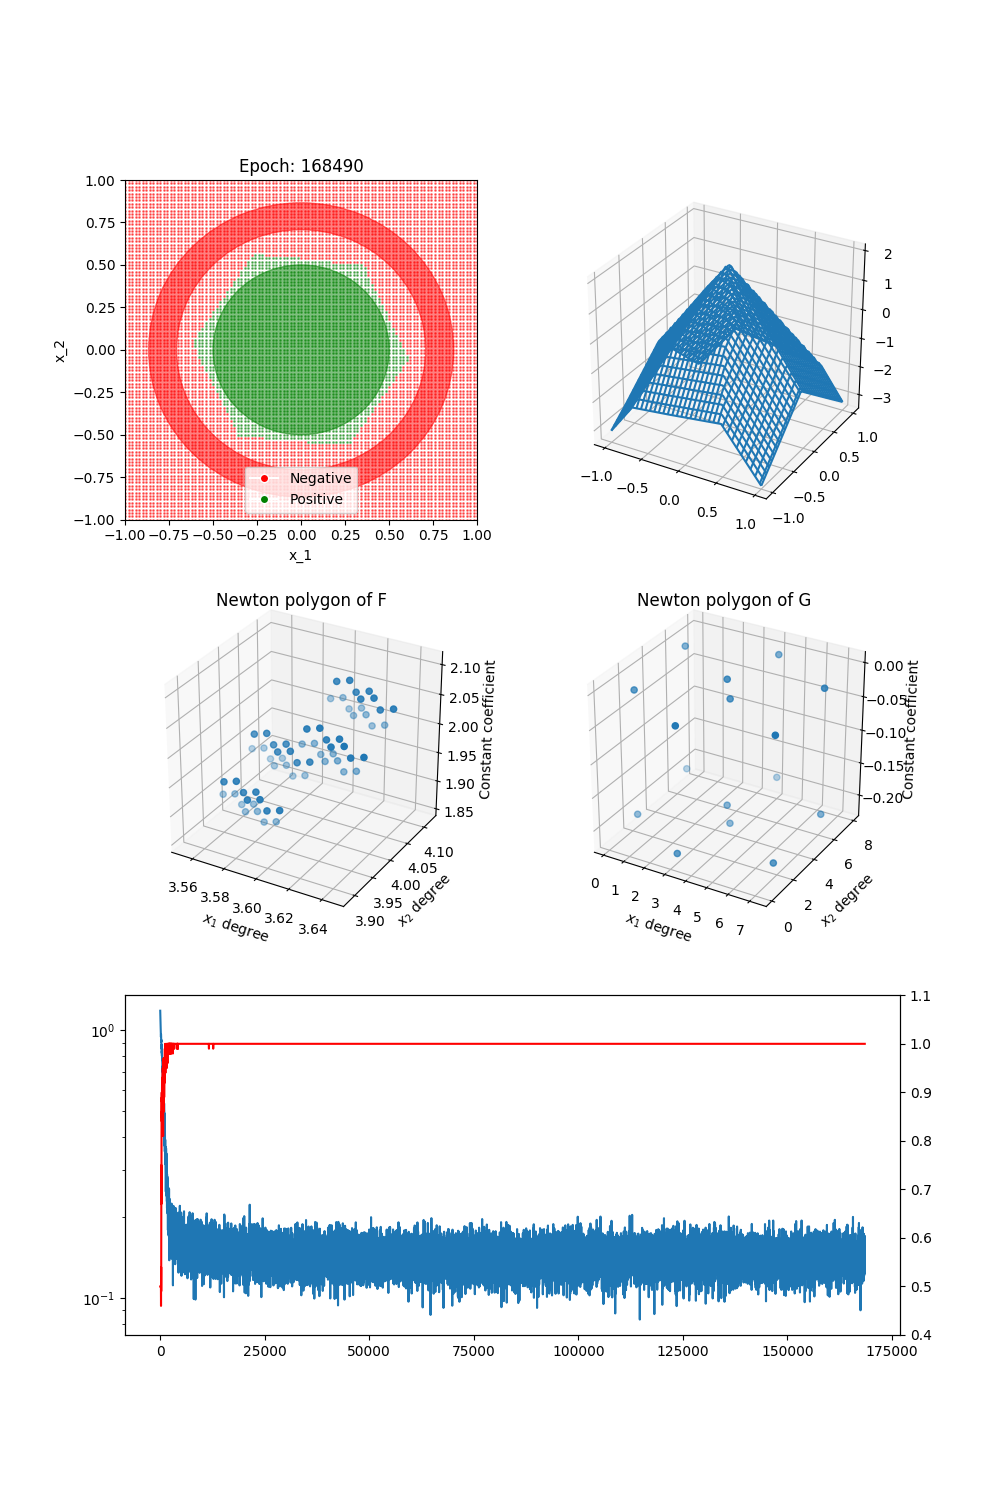

<IPython.core.display.Math object>

KeyboardInterrupt: 

In [16]:
# Run the network and display steps

# Data info
num_inputs = 2
num_outputs = 1
num_samples = 50
hidden_structure = [10]
r1 = 0.5
data_func = lambda n: data_gen2.circles(n, r1)

# Hyper-parameters 
num_epochs = 2000000
learning_rate = 0.001

# Setup for the network
model = NeuralNetwork(num_inputs, num_outputs, hidden_structure, learning_rate=learning_rate).to(device)

# Count the number of trainable parameters and display it
#print('Number of parameters:', model.num_params)

# Set up optimization technique
#loss_function = nn.BCEWithLogitsLoss() # Binary cross entropy
#loss_function = nn.CrossEntropyLoss() # Multi-class
#loss_function = nn.L1Loss() # L1 norm
loss_function = nn.MSELoss() # L2 norm divided by num samples 

# Setup for plotting progress
fig = plt.figure(figsize=(10, 15))
axTrain = fig.add_subplot(321)
axOut = fig.add_subplot(322, projection='3d')
axF = fig.add_subplot(323, projection='3d')
axG = fig.add_subplot(324, projection='3d')
axError = fig.add_subplot(313)
axRight = axError.twinx()
#fig.show()
#fig.canvas.draw()

thing = 101
x = np.linspace(-1, 1, thing)
y = np.linspace(-1, 1, thing)

X, Y = np.meshgrid(x, y)

x = np.reshape(X, thing**2)
y = np.reshape(Y, thing**2)

X_test = torch.from_numpy(np.vstack((x, y)).T).float()

out = Output(layout={'border': '1px solid black'})

tmp = display(Math(''))

training_acc = []
errors = []
epoch_list = []

for epoch in range(num_epochs):
    # Get the training data in a useful data structure
    inputData, _, _ = data_func(num_samples)
    X_train, y_train = inputData[:, 0:2], inputData[:, 2].reshape((-1, 1))
    X_train = torch.from_numpy(X_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    
    loss = model.train(X_train, y_train, loss_function)
    
    if (epoch+1) %10 == 0  or epoch == 0:
        # Display the running accuracy
        #print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, loss.item()))
        
        pred = model(X_train).detach().numpy()
        
        training_acc.append(np.sum((pred > 0) == (y_train.detach().numpy() > 0))/(len(pred)))
        errors.append(np.mean(np.power(pred - y_train.detach().numpy(), 2)))
        epoch_list.append(epoch+1)
        
        pred = model(X_test).detach().numpy()
        
        # Plot the classification map
        axTrain.clear()
        axOut.clear()
        axF.clear()
        axG.clear()
        axError.clear()
        axRight.clear()
        
        
        data_gen2.plotClassifierDataAlt(X_test, pred, plot=(fig, axTrain), alpha=0.5)
        inputData, _, _ = data_func(num_samples)
        X_train, y_train = inputData[:, 0:2], inputData[:, 2].reshape((-1, 1))
        #data_gen2.plotClassifierDataAlt(X_train, y_train, plot=(fig, axTrain))
        axTrain.add_artist(circle)
        axTrain.add_artist(annulus)
        axTrain.set_title('Epoch: ' + str(epoch+1))
        axTrain.set_xlabel('x_1')
        axTrain.set_ylabel('x_2')
        
        axOut.plot_wireframe(X, Y, pred.reshape(X.shape))
        
        
        params = []
        for param in model.parameters():
            params.append(param.detach().numpy())
        
        A1 = params[0]
        b1 = params[1]
        A2 = params[2]
        b2 = params[3]
        
        Fterms, Gterms = tropical.getTropCoeffs(A1, b1, A2, b2)
        
        tropical.newtonPolygon(Fterms, axF)
        axF.set_title('Newton polygon of F')
        
        tropical.newtonPolygon(Gterms, axG)
        axG.set_title('Newton polygon of G')
        
        
        axError.semilogy(epoch_list, errors)
        
        axRight.plot(epoch_list, training_acc, 'r')
        #axRight.plot(epoch_list, validation_acc, '--', c='m')
        axRight.set_ylim([0.4, 1.1])
        
        
        legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', label='Negative'),
                           matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', label='Positive')]
        axTrain.legend(handles=legend_elements)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        

In [8]:
#display(Math('F^{(2)} = ' + tropical.displayTropPoly(Fterms)))
print(params)

[array([[-0.14497364, -0.65663677],
       [ 0.56479144,  0.45072749],
       [ 2.03506637,  2.35767388],
       [ 0.85003138,  0.85908401],
       [-1.80220962,  1.55042565],
       [ 1.66355383, -1.46178365],
       [-0.39992544,  0.47314137],
       [ 0.68134445,  1.00729358]], dtype=float32), array([-0.62077892,  0.61480391, -0.00248732,  1.02434492, -0.79169142,
       -0.72342879, -0.69703639,  1.03268278], dtype=float32), array([[-0.08285227,  0.55662835, -1.87049878,  1.10273468, -1.86145687,
        -1.99233699,  0.1397675 ,  0.97484291]], dtype=float32), array([-0.91669375], dtype=float32)]


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
tropical.newtonPolygon(Fterms, ax)